In [60]:
import pprint
import collections
import os
import re

In [61]:
import string
import time

import graphviz
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pydot
from keras.callbacks import EarlyStopping
from keras.layers import (LSTM, Convolution1D, Dense, Dropout, Embedding,
                          Flatten, GlobalMaxPooling1D, MaxPooling1D,
                          SpatialDropout1D, concatenate)
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model

stopping_words = set(stopwords.words('english'))




lemmatizer_wordnet = WordNetLemmatizer()


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [62]:
start = time.time()

data = pd.read_csv("C:\Users\Joel\Desktop\twitter_sentiment_analysis\Tweets.csv")

In [63]:
t_tweets = data['text']

In [64]:
t_tweets

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [65]:

data.sample(100)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
4747,569880788612866048,negative,1.0000,Late Flight,1.0000,Southwest,NaN,ucsigmachi,NaN,0,@SouthwestAir flight 1028 no delayed 1.5 hours...,NaN,2015-02-23 07:25:42 -0800,NaN,NaN
12069,570300915418320897,negative,1.0000,Cancelled Flight,1.0000,American,NaN,LancasterPattie,NaN,0,@AmericanAir You are jumping the gun and Cance...,NaN,2015-02-24 11:15:08 -0800,NaN,NaN
13515,569844028365275136,negative,1.0000,Lost Luggage,1.0000,American,NaN,LeslieWolfson,NaN,0,@AmericanAir Pathetic answer. Just found out m...,NaN,2015-02-23 04:59:38 -0800,Miami Beach,Central Time (US & Canada)
4936,569630183747153920,negative,1.0000,Cancelled Flight,0.6639,Southwest,NaN,soylentgs,NaN,0,@SouthwestAir Had a very unpleasant experience...,NaN,2015-02-22 14:49:53 -0800,Missouri,Central Time (US & Canada)
1411,569730682949398528,positive,1.0000,NaN,NaN,United,NaN,JasmineDT,NaN,0,@united you're my early frontrunner for best a...,NaN,2015-02-22 21:29:14 -0800,Washington D.C.,Eastern Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12726,570044332843134976,positive,1.0000,NaN,NaN,American,NaN,momsgoodeats,NaN,0,"Still thinking, those PJs may have me sold @Am...",NaN,2015-02-23 18:15:34 -0800,#Omaha,Central Time (US & Canada)
7384,569630310779854848,negative,1.0000,Late Flight,1.0000,Delta,NaN,Tom_Constantin,NaN,0,@JetBlue anything serious I should worry about?,NaN,2015-02-22 14:50:23 -0800,3Ø4,Quito
1159,569910536755748865,negative,1.0000,Late Flight,0.3511,United,NaN,MrEschatologist,NaN,0,@United has two whole people trying to schedul...,NaN,2015-02-23 09:23:55 -0800,"Arlington, VA",NaN
12154,570275248052039680,negative,0.5014,Customer Service Issue,0.5014,American,NaN,RobertDwyer,NaN,0,@AmericanAir that doesn't really answer my que...,NaN,2015-02-24 09:33:08 -0800,"Wellesley, MA",Eastern Time (US & Canada)


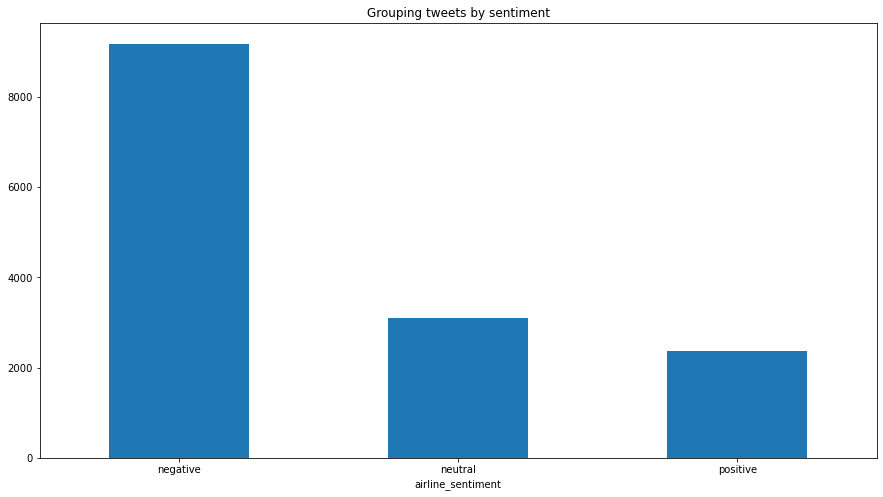

In [66]:

tweet_sentiment_group = data.groupby(['airline_sentiment']).count()
tweet_sentiment_group.plot(kind='bar', figsize=(15, 8), rot=0, legend=False, title='Grouping tweets by sentiment', y='tweet_id');

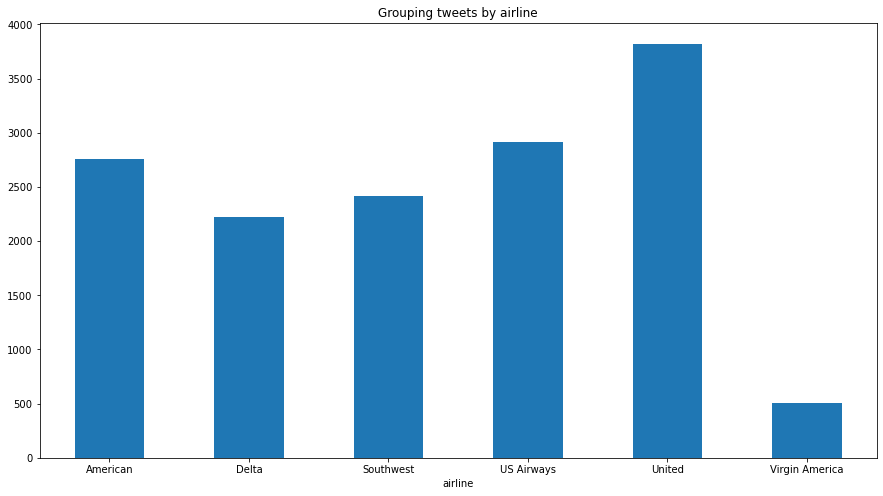

In [67]:

tweet_airline_group = data.groupby(['airline']).count()
tweet_airline_group.plot(kind='bar', figsize=(15, 8), rot=0, legend=False, title='Grouping tweets by airline', y='tweet_id');

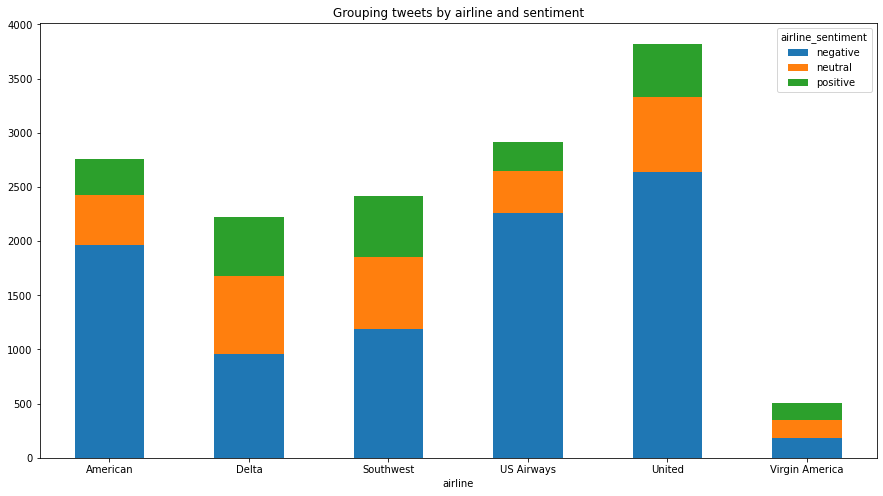

In [68]:
groupedByAirline = data.groupby(['airline', 'airline_sentiment']).count().unstack()
groupedByAirline.plot(kind='bar', figsize=(15, 8), rot=0, stacked=True,  title='Grouping tweets by airline and sentiment', y='tweet_id');

In [69]:

reasons_tweet = data[['airline','negativereason']]
tweet_reason_group = reasons_tweet.groupby('negativereason', as_index=False).count()
tweet_reason_group.sort_values('airline', ascending=False)

,negativereason,airline
3,Customer Service Issue,2910
7,Late Flight,1665
1,Can't Tell,1190
2,Cancelled Flight,847
8,Lost Luggage,724
0,Bad Flight,580
6,Flight Booking Problems,529
5,Flight Attendant Complaints,481
9,longlines,178
4,Damaged Luggage,74


In [70]:
def preprocess(t_tweet):

    # "@user"
    t_tweet = re.sub('@[\w]*',"",t_tweet)

    # URLs
    t_tweet  = re.sub('((www\.[\S]+)|(https?://[\S]+))',"",t_tweet)

    # Letters Only
    t_tweet = re.sub('[^a-zA-Z\s]'," ", t_tweet)
    t_tweet = re.sub('\s[a-zA-z]\s'," ", t_tweet)

    # lowercase
    t_tweet = t_tweet.lower()

    #tokens
    t_tweet = word_tokenize(t_tweet)

    #stopwords
    t_tweet = list(filter(lambda l: l not in stopping_words, t_tweet))

    t_tweet = [lemmatizer_wordnet.lemmatize(word) for word in t_tweet]

    return t_tweet

t_tweets = t_tweets.apply(preprocess)

In [71]:
NUM_WORDS = 3000

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(t_tweets)




X = tokenizer.texts_to_sequences(t_tweets)


X = pad_sequences(X)

print(X)

[[   0    0    0 ...    0    0  122]
 [   0    0    0 ...  928 1062  104]
 [   0    0    0 ...   62   70   96]
 ...
 [   0    0    0 ...  491  323   23]
 [   0    0    0 ...  887   42 2031]
 [   0    0    0 ...   66   93    1]]


In [72]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 111)
X_train, val_X, Y_train, val_Y = train_test_split(X_train, Y_train, test_size=0.1, random_state=1)
print('Train dataset', X_train.shape,Y_train.shape)
print('Validation dataset', val_X.shape, val_Y.shape)
print('Test dataset', X_test.shape,Y_test.shape)

Train dataset (9882, 21) (9882, 3)
Validation dataset (1098, 21) (1098, 3)
Test dataset (3660, 21) (3660, 3)


In [73]:
model = Sequential()

model.add(Embedding(NUM_WORDS, 96, input_length = X.shape[1] ))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 21, 96)            288000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 291       
Total params: 362,403
Trainable params: 362,403
Non-trainable params: 0
_________________________________________________________________
None


In [74]:

def compileAndFitModel(model, opt):
    model.save_weights('my_model.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    BATCH_SIZE = 24
    EPOCHS = 5
    early_stoppage = EarlyStopping(monitor='val_acc', patience=2, mode='max')
    print()
    print('-------------------------- Method of Optimization: ', opt ,'--------------------------')
    print()
    model.fit(X_train, Y_train, BATCH_SIZE, epochs=EPOCHS,
                validation_data=(val_X, val_Y),
                callbacks=[early_stoppage] )
    model.load_weights('my_model.h5')

In [75]:
optim = ['Adam', 'RMSprop','Adamax', 'Nadam', 'SGD', 'Adadelta', 'Adagrad']
for opt in optim:
    compileAndFitModel(model, opt)


-------------------------- Method of Optimization:  Adam --------------------------

Epoch 1/5
412/412 [==============================] - 37s 91ms/step - loss: 0.7052 - accuracy: 0.7123 - val_loss: 0.5579 - val_accuracy: 0.7832
Epoch 2/5
412/412 [==============================] - 37s 90ms/step - loss: 0.4658 - accuracy: 0.8158 - val_loss: 0.5326 - val_accuracy: 0.7823
Epoch 3/5
412/412 [==============================] - 36s 88ms/step - loss: 0.3895 - accuracy: 0.8489 - val_loss: 0.5691 - val_accuracy: 0.7796
Epoch 4/5
412/412 [==============================] - 37s 90ms/step - loss: 0.3405 - accuracy: 0.8693 - val_loss: 0.5773 - val_accuracy: 0.7832
Epoch 5/5
412/412 [==============================] - 37s 89ms/step - loss: 0.3063 - accuracy: 0.8853 - val_loss: 0.6259 - val_accuracy: 0.7905

-------------------------- Method of Optimization:  RMSprop --------------------------

Epoch 1/5
412/412 [==============================] - 35s 86ms/step - loss: 0.7257 - accuracy: 0.6965 - val_los

In [76]:
model.compile(loss='categorical_crossentropy',
                  optimizer='Adagrad',
                  metrics=['accuracy'])

In [77]:

BATCH_SIZE = 24
EPOCHS = 10
early_stoppage = EarlyStopping(monitor='val_acc', patience=2, mode='max')
history = model.fit(X_train, Y_train, BATCH_SIZE, epochs=EPOCHS,
            validation_data=(val_X, val_Y),
            callbacks=[early_stoppage] )

Epoch 1/10
412/412 [==============================] - 35s 85ms/step - loss: 1.0699 - accuracy: 0.6175 - val_loss: 1.0485 - val_accuracy: 0.6302
Epoch 2/10
412/412 [==============================] - 36s 87ms/step - loss: 1.0322 - accuracy: 0.6247 - val_loss: 1.0137 - val_accuracy: 0.6302
Epoch 3/10
412/412 [==============================] - 34s 83ms/step - loss: 0.9960 - accuracy: 0.6247 - val_loss: 0.9738 - val_accuracy: 0.6302
Epoch 4/10
412/412 [==============================] - 36s 87ms/step - loss: 0.9560 - accuracy: 0.6247 - val_loss: 0.9359 - val_accuracy: 0.6302
Epoch 5/10
412/412 [==============================] - 34s 83ms/step - loss: 0.9293 - accuracy: 0.6247 - val_loss: 0.9200 - val_accuracy: 0.6302
Epoch 6/10
412/412 [==============================] - 36s 86ms/step - loss: 0.9216 - accuracy: 0.6247 - val_loss: 0.9167 - val_accuracy: 0.6302
Epoch 7/10
412/412 [==============================] - 35s 85ms/step - loss: 0.9195 - accuracy: 0.6247 - val_loss: 0.9153 - val_accuracy:

In [78]:
def plot_history(history):



    namesMetrics = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(namesMetrics):


        metric_values_train = history.history.get(metric, [])


        values_metric_val = history.history.get("val_{}".format(metric), [])


        epochs = range(1, len(metric_values_train) + 1)


        text_training = "   Train {}: {:.4f}".format(metric,
                                                        metric_values_train[-1])


        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_values_train,
                 'b',
                 label=text_training)


        if values_metric_val:
            text_validation = "Validation {}: {:.4f}".format(metric,
                                                             values_metric_val[-1])

            plt.plot(epochs,
                     values_metric_val,
                     'g',
                     label=text_validation)


        plt.title('Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

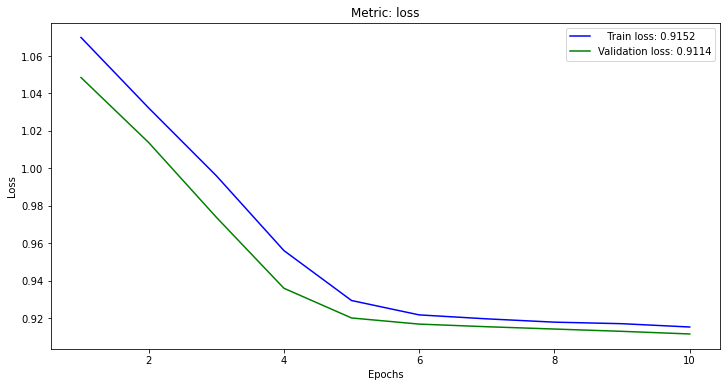

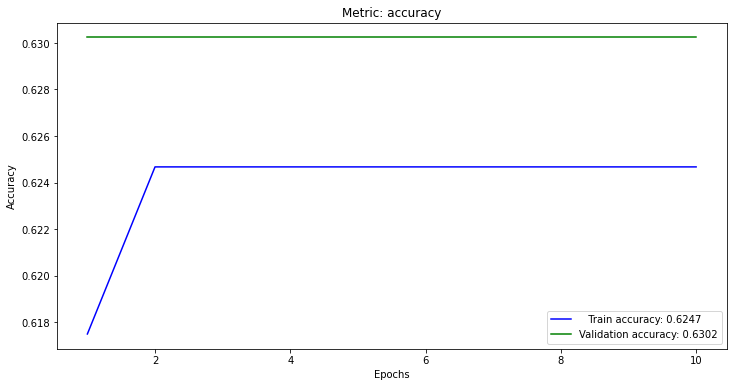

In [79]:
plot_history(history)

In [80]:
performance = model.evaluate(
    X_test,
    Y_test,
    batch_size=24,
    verbose=1
)

print('\nScore Test Categorical Entropy:', performance[0])
print('\nScore Test Accuracy:', performance[1])

153/153 [==============================] - 1s 7ms/step - loss: 0.9043 - accuracy: 0.6320

Score Test Categorical Entropy: 0.904261589050293

Score Test Accuracy: 0.6319671869277954


In [81]:
#"@user"
t_tweets = t_tweets.apply((lambda x: re.sub('@[\w]*',"",str(x))))

#URLs
t_tweets = t_tweets.apply((lambda x: re.sub('((www\.[\S]+)|(https?://[\S]+))',"",str(x))))

#Letters Only
t_tweets = t_tweets.apply((lambda x: re.sub('[^a-zA-Z]'," ",x)))

In [82]:
t_tweets.head()

0                                               said  
1      plus    added    commercial    experience   ...
2      today    must    mean    need    take    ano...
3      really    aggressive    blast    obnoxious  ...
4                      really    big    bad    thing  
Name: text, dtype: object

In [83]:

def rep_remover(replet):

    replet = re.sub(r'(.)\1+', r'\1\1', str(replet))

    return replet


t_tweets = np.vectorize(rep_remover)(t_tweets)
t_tweets

array(['  said  ', '  plus  added  commercial  experience  tacky  ',
       '  today  must  mean  need  take  another  trip  ', ...,
       '  please  bring  american  airline  blackberry  ',
       '  money  change  flight  answer  phone  suggestion  make  commitment  ',
       '  ppl  need  know  many  seat  next  flight  plz  put  u  standby  people  next  flight  '],
      dtype='<U152')

In [84]:


le = LabelEncoder()
data['classes'] = le.fit_transform(data['airline_sentiment'])

In [85]:


length = []
for x in t_tweets:
    length.append(len(x.split()))
max(length)

21

In [86]:
maxlen=40
NUM_WORDS = 6000

In [87]:

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(t_tweets)





T = tokenizer.texts_to_sequences(t_tweets)


X = pad_sequences(T, maxlen=40)
X

array([[   0,    0,    0, ...,    0,    0,  122],
       [   0,    0,    0, ..., 1062,  104, 5133],
       [   0,    0,    0, ...,   62,   70,   96],
       ...,
       [   0,    0,    0, ...,  491,  323,   23],
       [   0,    0,    0, ...,  887,   42, 2035],
       [   0,    0,    0, ...,   66,   93,    1]], dtype=int32)

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X,data['classes'], test_size = 0.2, random_state = 111)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11712, 40) (11712,)
(2928, 40) (2928,)


In [89]:
X.shape[1]

40

In [90]:

y_encoded = np_utils.to_categorical(Y_train)
test_y_endoded = np_utils.to_categorical(Y_test)






def model_cnn():
    model = Sequential([Embedding(input_dim = NUM_WORDS, output_dim = 32, input_length = maxlen),
                        Convolution1D(64, 2, padding='same', activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(25, activation='relu'),
                        Dropout(0.2),
                        Dense(3, activation='softmax')])






    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [91]:
model = model_cnn()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 32)            192000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 40, 64)            4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                32025     
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

In [92]:
model = model_cnn()



history = model.fit(X_train, y_encoded, validation_data=(X_test, test_y_endoded), epochs=5, batch_size=100)

Epoch 1/5
118/118 [==============================] - 1s 6ms/step - loss: 0.8227 - accuracy: 0.6408 - val_loss: 0.7027 - val_accuracy: 0.6971
Epoch 2/5
118/118 [==============================] - 1s 5ms/step - loss: 0.6284 - accuracy: 0.7297 - val_loss: 0.6356 - val_accuracy: 0.7411
Epoch 3/5
118/118 [==============================] - 1s 5ms/step - loss: 0.5052 - accuracy: 0.7959 - val_loss: 0.6003 - val_accuracy: 0.7558
Epoch 4/5
118/118 [==============================] - 1s 5ms/step - loss: 0.4153 - accuracy: 0.8391 - val_loss: 0.6029 - val_accuracy: 0.7722
Epoch 5/5
118/118 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8783 - val_loss: 0.6074 - val_accuracy: 0.7664


In [93]:
def plot_history(history):



    namesMetrics = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(namesMetrics):


        metric_values_train = history.history.get(metric, [])


        values_metric_val = history.history.get("val_{}".format(metric), [])


        epochs = range(1, len(metric_values_train) + 1)


        text_training = "   Train {}: {:.4f}".format(metric,
                                                        metric_values_train[-1])


        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_values_train,
                 'b',
                 label=text_training)


        if values_metric_val:
            text_validation = "Validation {}: {:.4f}".format(metric,
                                                             values_metric_val[-1])

            plt.plot(epochs,
                     values_metric_val,
                     'g',
                     label=text_validation)


        plt.title('Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

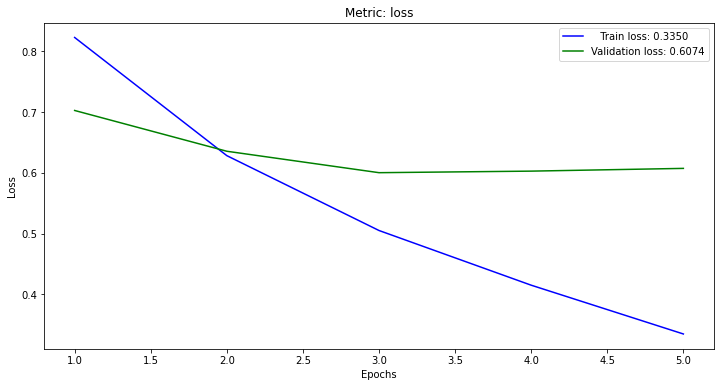

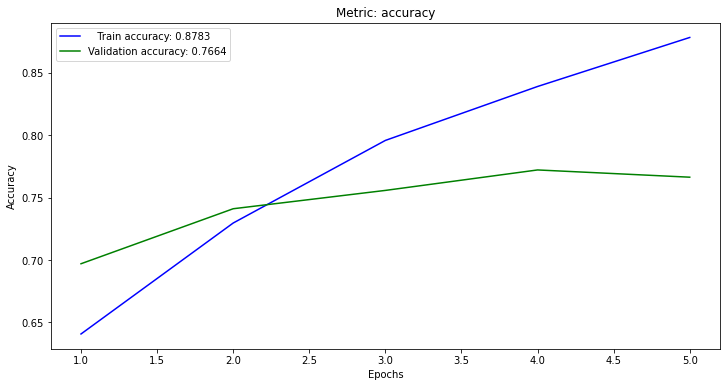

In [94]:
plot_history(history)

In [95]:
predictions = model.predict(X_test)

In [103]:
print(metrics.classification_report(Y_test, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1844
           1       0.55      0.62      0.58       637
           2       0.72      0.72      0.72       447

    accuracy                           0.77      2928
   macro avg       0.71      0.72      0.72      2928
weighted avg       0.77      0.77      0.77      2928



In [96]:
metrics.accuracy_score(Y_test, np.argmax(predictions, axis=1))

0.7663934426229508

In [97]:
def model_cnn():
    cnnModel = Sequential([Embedding(input_dim = NUM_WORDS, output_dim = 32, input_length = maxlen),
                        Convolution1D(128, 3, padding='same', activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(25, activation='relu'),
                        Dropout(0.2),
                        Dense(3, activation='softmax')])




    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [98]:
cnnModel = model_cnn()
cnnModel.fit(X_train, y_encoded, validation_data=(X_test, test_y_endoded), epochs=4, batch_size=100)

Epoch 1/4
118/118 [==============================] - 1s 6ms/step - loss: 0.2748 - accuracy: 0.9043 - val_loss: 0.6958 - val_accuracy: 0.7678
Epoch 2/4
118/118 [==============================] - 1s 5ms/step - loss: 0.2241 - accuracy: 0.9238 - val_loss: 0.7059 - val_accuracy: 0.7613
Epoch 3/4
118/118 [==============================] - 1s 7ms/step - loss: 0.1858 - accuracy: 0.9412 - val_loss: 0.8171 - val_accuracy: 0.7650
Epoch 4/4
118/118 [==============================] - 1s 5ms/step - loss: 0.1549 - accuracy: 0.9501 - val_loss: 0.8517 - val_accuracy: 0.7579


In [99]:
predictions_2 = cnnModel.predict(X_test)

In [100]:
metrics.accuracy_score(Y_test, np.argmax(predictions_2, axis=1))

0.7578551912568307

In [101]:
end = time.time()
print(end - start)

1635.9017391204834
